# Week1
## Load package

In [2]:
# libraries
import torch
from torch.utils.data import Dataset,DataLoader
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
# local imports
import MNIST_dataloader
from scipy import linalg
import os
import bokeh
from ISTA import ISTAI_main
PATH = os.path.join(os.getcwd(),'Fast_MRI_Knee')
print('Folders in the Fast_MRI_Knee:',os.listdir(PATH)) # os.listdir(PATH)
# Batch size
batch_size = 64
# Load train and test
train_loader, test_loader = MNIST_dataloader.create_dataloaders(PATH, batch_size)

if  torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Folders in the Fast_MRI_Knee: ['MNIST', 'test', 'train']


## Plot the example

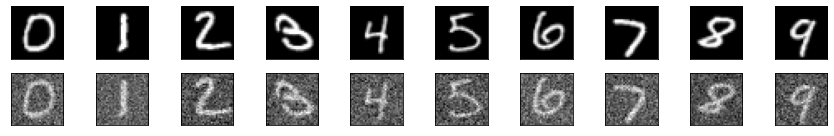

In [3]:
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)
plt.figure(figsize=(12,2))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2,10,i+11)
    plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    

    
plt.tight_layout()
# plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
plt.show()


In [4]:
# Load data
x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels

x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels

# use these 10 examples as representations for all digits
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]

Data shape and matrix shape.

In [6]:
x_clean_train.size() #60000 examples of 28x28 pixels in grayscale torch.Size([60000, 1, 32, 32])

(x_clean_example[0])
# tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
#          [-1., -1., -1.,  ..., -1., -1., -1.],
#          [-1., -1., -1.,  ..., -1., -1., -1.],
#          ...,
#          [-1., -1., -1.,  ..., -1., -1., -1.],
#          [-1., -1., -1.,  ..., -1., -1., -1.],
#          [-1., -1., -1.,  ..., -1., -1., -1.]]])

x_clean_example[0][0] # [1, 32, 32]) --> 1, 1024

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])

## a - Implement ISTA for MNIST denoising.
Input requires Stepsize - `mu`, shrinkage parameter - `shrinkage`, number of iteration `K`, and measurement Batch of MNIST images[10 images \ Matrix] `y`.

Output reconstructions `x_k`. \
In the soft thershold. \
$$
\begin{equation*}
    soft_T(x)= sign(x_i)(|x_i|-T)
\end{equation*}
$$

$\alpha$ - step size 

$g_1 = A^T(y-Ax_1)$ 

$x_2 = x_1 + \alpha * (A^T(y-Ax_1)) $ 

$\hat{x}=sign(x_2)max(|x_2|-\alpha*\lambda,0)$  -  the last estimate

`reconstruction error error`

$error(i,1) = \frac{norm|(\hat{x} - x_1)|}{ norm|(\hat{x})|} $

## ISTA


In [17]:
y = x_noisy_example[0]
A = torch.diag_embed(torch.flatten(y))
x = torch.zeros(len(torch.flatten(y))) 
print(x)
torch.transpose(A,0,1)

tensor([0., 0., 0.,  ..., 0., 0., 0.])


tensor([[-1.2583,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.7971,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.3098,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.1113,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -1.1711,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.5095]])

In [32]:
from matplotlib.image import imread
import numpy as np
from scipy import linalg
import torch

class ISTAI_main(object):
    def __init__(self):
        # ,mu,shrinkage,K,y
        super(ISTAI_main, self).__init__()
        # self.mu = mu                # Step size
        # self.shrinkage = shrinkage  # shrinkage parameters 
        # self.K = K                  # Interation
        # self.y=y

    
    def softthreshold(self,x,theta):        
        # torch.sign(x) Returns a new tensor with the signs of the elements of input.
        return torch.multiply(torch.sign(x) ,torch.maximum(torch.abs(x) - theta, torch.tensor(0.)))

    def ISTA(self,mu,lmbd,K,y:torch.tensor)->torch.tensor:
        """
        y = A  # input each batch
        """        
        # 32,32
        A = torch.diag_embed(torch.flatten(y)) # Diagnoal matrix - diagonal length = 1024
        x = torch.zeros(len(torch.flatten(y))) # 1024 zero
        error = []
        for i in range(K):
            g = torch.transpose(A,0,1)@(torch.flatten(y)-A@x) 
            x_2 = x +mu*g
            shrinkage = mu*lmbd
            x_hat = self.softthreshold(x_2, shrinkage)            
            error = torch.nn.functional.mse_loss(x_hat,x)
            if error < 1e-7:
                break
            else:
                x = x_hat

        return torch.tensor(x_hat)

    # def forward(self,mu,lmbd,K,y):
    #     x_hat, error = self.ISTA(mu,lmbd,K,y)
    #     return x_hat, error

/var/folders/1c/q7z9b1p53w919xfjr1rjxvvm0000gn/T/ipykernel_1208/2497160285.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_hat)


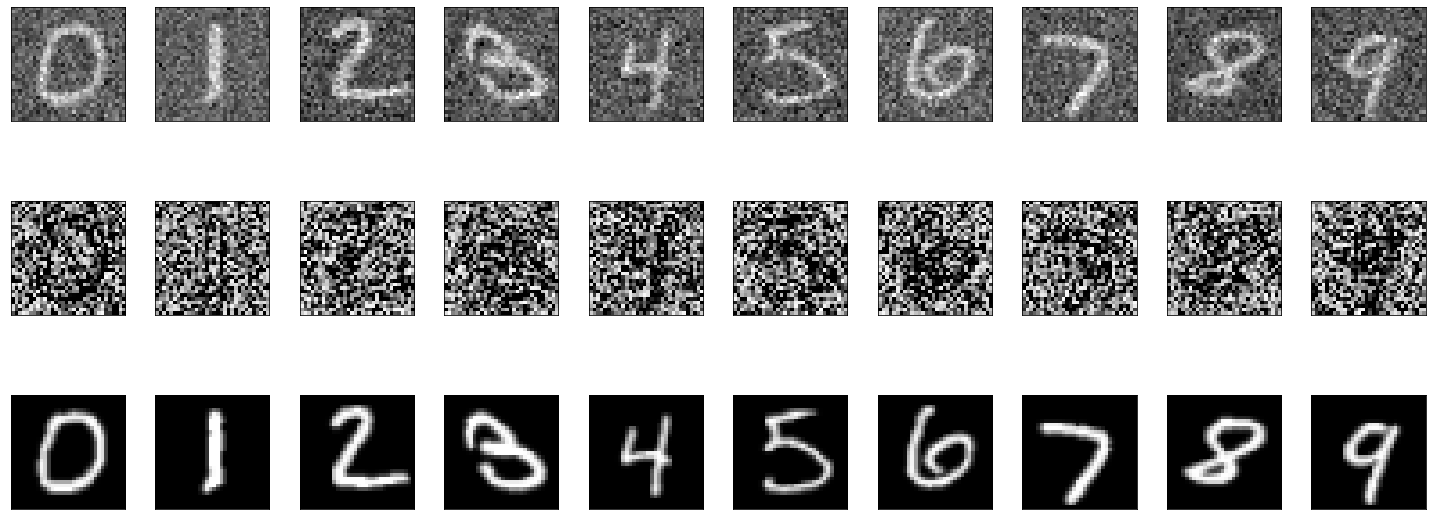

In [37]:
# ------------Tuning parameters-----------------------------------
mu = 0.01
lmbd = 0.3
K=100
# ----------------------------------------------------------------
Ex1 = ISTAI_main()
x_hat = dict()
for i in range(10):
    y = x_noisy_example[i,0,:,:]
    with torch.no_grad():
        x_hat[i]= Ex1.ISTA(mu,lmbd,K,y)
fig = plt.figure(figsize=(20,10))
for i in range(10):
    ax1 = fig.add_subplot(3, 10, i+1)
    ax1.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout()
    plottable_image = x_hat[i].reshape([32,32])
    ax = fig.add_subplot(3, 10, i+11)
    ax.imshow(plottable_image,cmap='gray')
    plt.tight_layout()
    plt.yticks([])
    plt.xticks([])
    ax2 = fig.add_subplot(3, 10, i+21)
    ax2.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.tight_layout()
    plt.yticks([])
    plt.xticks([])
